# Configs

In [2]:
### Imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pygwalker as pyg

In [3]:
### Setup
ROOT = '..'
EXTENSION = 'parquet'
DATA_FOLDER = 'data'

# EDA

## Base dataset

In [68]:
train = pd.read_parquet(f'{ROOT}/{DATA_FOLDER}/train/train_base.{EXTENSION}')
train.head(2)

,case_id,date_decision,MONTH,WEEK_NUM,target
0,0,2019-01-03,201901,0,0
1,1,2019-01-03,201901,0,0


In [57]:
train['date_decision'] = pd.to_datetime(train['date_decision'])

In [61]:
print("""
Shape: {}
Temporal span training:
    min = {}
    max = {}
Target distribution: 
    class 0 = {:.2f}
    class 1 = {:.2f}
""".format(
    train.shape,
    train['date_decision'].dt.date.min(),
    train['date_decision'].dt.date.max(),
    train.loc[train['target']==0].shape[0]*100/train.shape[0],
    train.loc[train['target']==1].shape[0]*100/train.shape[0]
    )
)


Shape: (1526659, 5)
Temporal span training:
    min = 2019-01-01
    max = 2020-10-05
Target distribution: 
    class 0 = 96.86
    class 1 = 3.14



> Insights
>
> - Data from 2019 to 2020 
> - Unbalanced 97/3

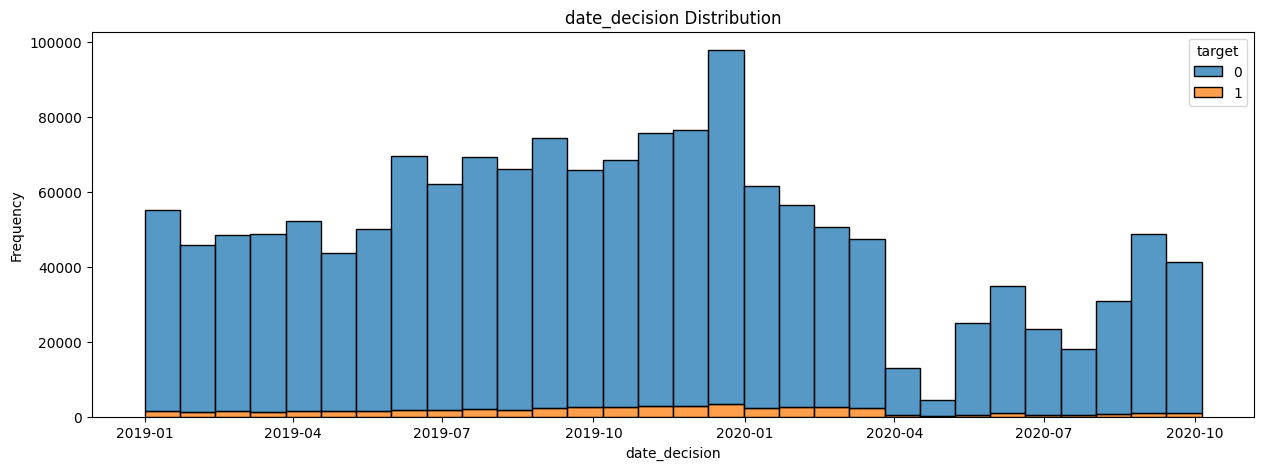

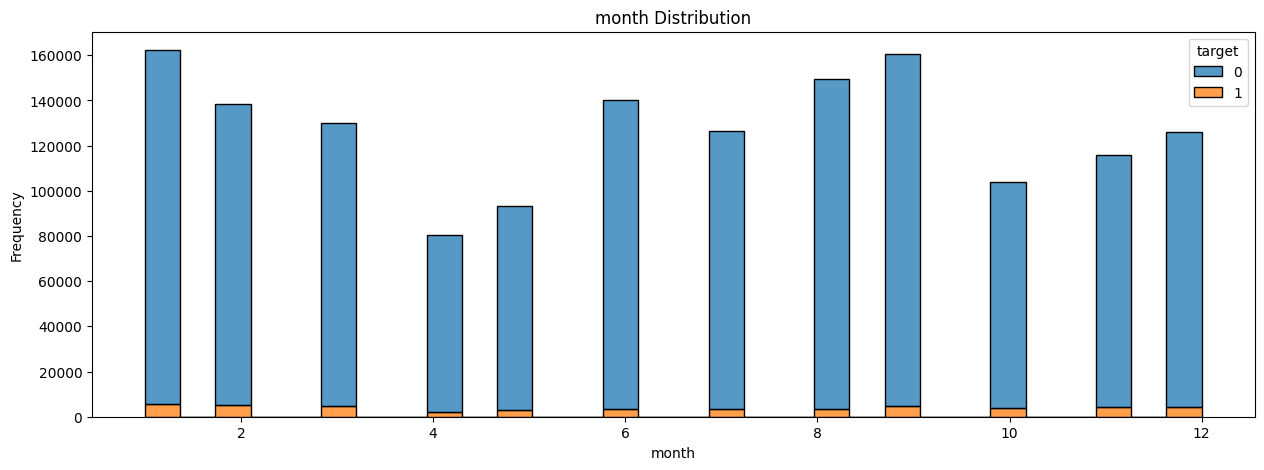

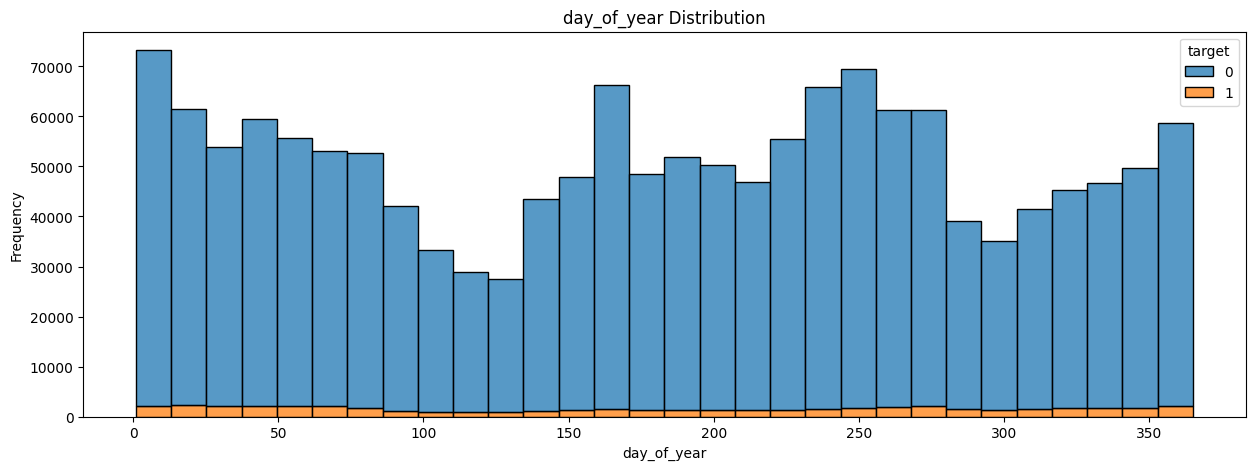

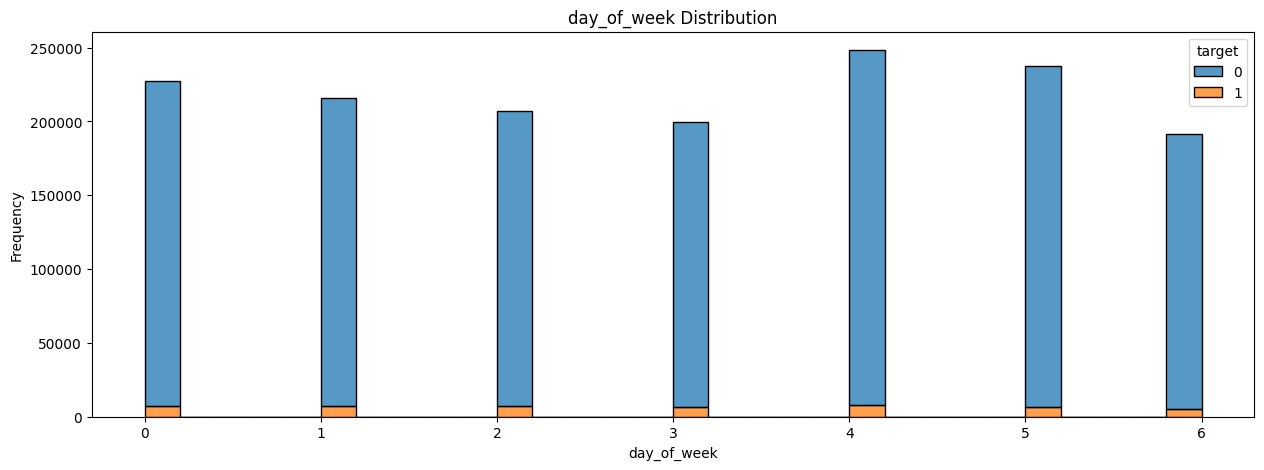

In [67]:
def plot_date_components(df, component):
    plt.figure(figsize=(15, 5))
    sns.histplot(data=df, x=component, bins=30, multiple="stack", kde=False, hue='target')
    plt.title(f'{component} Distribution')
    plt.xlabel(component)
    plt.ylabel('Frequency')
    plt.show()

train['month'] = train.date_decision.dt.month
train['day_of_year'] = train.date_decision.dt.day_of_year
train['day_of_week'] = train.date_decision.dt.day_of_week

plot_date_components(train, 'date_decision')
plot_date_components(train, 'month')
plot_date_components(train, 'day_of_year')
plot_date_components(train, 'day_of_week')

> Insights
>
> - No "holes" in date features
> - Impact of covid to be considered in feature engineering
> - class imbalance looks pretty constant in aggregated features

## Overview other tables

In general, it looks like external data are any datasets used by an organization without [having being produced internally by the organization (in this case, Home Credit).](https://www.openriskmanual.org/wiki/External_Risk_Data)

So we have internal files and external files, classified by depth (info taken from description and from [here](https://www.kaggle.com/competitions/home-credit-credit-risk-model-stability/discussion/476763)):
- `depth 0`: static features. There are attributes that are aggregated on `case_id` level. Example can be age of client or gender, 1 records per 1 `case_id`.
- `depth 1`: each `case_id` is associated with historical record (`num_group1`). Those are attributes where Home Credit have several records per client/application. Example can be previous applications or loans in credit bureau register, each client can have from 0 to n records. Therefore, for one `case_id` there might be several records, and to index them they use `num_group1`
- `depth 2`: each `case_id` is associated with historical record (`num_group1` and `num_group2`). For some attributes with depth=1 they have more detailed information, for example for previous applications they have data about installments like date of payments or days past due of each payments. It means for each previous application, we can have 0…n records about instalments/payments. And as an index is used `num_group2`

in which, various predictors were transformed:
- `P`: Transform DPD (Days past due), example `actualdpd_943P`
- `M`: Masking categories, example `maritalst_385M`
- `A`: Transform amount, example `pmtssum_45A`
- `D`: Transform date, example `dateofbirth_337D`
- `T`: Unspecified Transform, example `riskassessment_940T`
- `L`: Unspecified Transform, example `pmtcount_4955617L`

Here's a good image found on Kaggle that summarizes the situation:

<img src="../doc/summarytables.png" alt="drawing" style="width:800px;"/>

---

From the [previous Home Credit competition](https://www.kaggle.com/competitions/home-credit-default-risk/data), we can get a general idea of the purpose of some tables:

### *_bureau tables
All client's previous credits provided by other financial institutions
that were reported to Credit Bureau (for clients who have a loan in sample).
For every loan, there are as many rows as number of credits the client had in Credit Bureau before the application date.

### *_applprev: 
All previous applications for Home Credit loans of clients who have loans in sample.
There is one row for each previous application related to loans in data sample.

### _debitcard,  _deposit_1, _other: (equivalent of credit_card_balance)
Balance snapshots of previous credit cards that the applicant has with Home Credit.\
They contain few columns such as `last180dayaveragebalance_704A` (average balance on debit card in the last 180 days) and `last30dayturnover_651A` (debit card turnover for the last 30 days) or `amount_416A` (deposit amount).

---
Then we can make some assumptions of the remaining tables:

### *_static:
Big files (168 columns) apparently containing information about the loan (depth 0)

### *_tax_registry: 
The [Tax Registry](https://www.cbi-org.eu/Tax-Registry) is a tool that, for assessment and control activities, contains knowledge about all of the subjects registered in it, whether individuals or legal entities that have a tax identification number. The creation of this database, and in particular of a section contained therein called Financial Accounts Archive, enables the relevant Institutions to quickly access the data on the subjects to be checked and to instantly identify the banks or financial operators with which they have accounts.\
There is one relevant column, that is `amount_4527230A` (tax deductions amount tracked by the government registry).

### *_person:
Information about the person.

## Explore the tables
The following code can be used to explore the tables. Use the `feature_definitions.csv` data to get an idea of the meaning of a given column.

In [30]:
# Code use to explore columns
train_other = pd.read_parquet(f'{ROOT}/{DATA_FOLDER}/train/train_person_1.{EXTENSION}')
column_explanation = pd.read_csv(f'{ROOT}/doc/feature_definitions.csv')

In [31]:
column_explanation.head(2)

,Variable,Description
0,actualdpd_943P,Days Past Due (DPD) of previous contract (actu...
1,actualdpdtolerance_344P,DPD of client with tolerance.


In [38]:
for i in train_other.columns:
    if i in column_explanation.Variable.values:
        print(i, '\t--->', column_explanation.loc[column_explanation['Variable']==i, 'Description'].item())
    else:
        print('Column {} is missing in the mapping'.format(i))

Column case_id is missing in the mapping
birth_259D 	---> Date of birth of the person.
birthdate_87D 	---> Birth date of the person.
childnum_185L 	---> Number of children of the applicant.
contaddr_district_15M 	---> Zip code of a contact person's address.
contaddr_matchlist_1032L 	---> Indicates whether the contact address is found in a code list.
contaddr_smempladdr_334L 	---> Indicates whether the contact address is the same as the employment address.
contaddr_zipcode_807M 	---> Zip code of contact address.
education_927M 	---> Education level of the person.
empl_employedfrom_271D 	---> Start date of employment.
empl_employedtotal_800L 	---> Employment length of a person.
empl_industry_691L 	---> Employment Industry of the person.
empladdr_district_926M 	---> District where the employer's address is located.
empladdr_zipcode_114M 	---> Zipcode of employer's address.
familystate_447L 	---> Family state of the person.
gender_992L 	---> Gender of a person.
housetype_905L 	---> House t